## Part 1: Predicting Customer Churn using Neural Networks
### Objective: 
The objective of this assignment is to develop a deep learning model that can predict customer churn for a telecom company. You will use a dataset containing customer information, and whether or not the customer churned.

In [3]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import os
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
display.set_matplotlib_formats('svg')

# for warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\athorat\AppData\Local\Temp\ipykernel_36792\397243550.py:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


#### 2. Load the dataset and perform exploratory data analysis.

In [4]:
os.chdir('C:/Users/athorat/OneDrive - Nice Systems Ltd/00_Amit Thorat Data/ISB - AMPBA/01_Project/Term4_DL\Assignment\Part 1')
custData = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
custData.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
custData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Univariate Analysis

<Axes: >

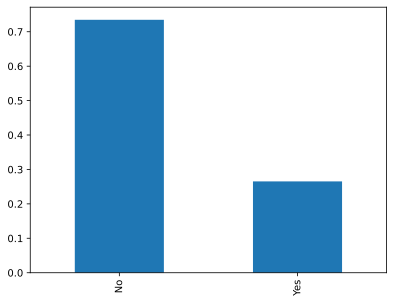

In [6]:
# Target Variable
custData.Churn.value_counts(normalize = True).plot(kind = "bar")

In [7]:
# Split the Customer ID
custData.customerID[0].split("-")[1]

'VHVEG'

In [8]:
# Split the Customer ID
ids = []

for i in custData.customerID:
    ids.append(i.split("-")[1])

In [9]:
# Creating a New Column called Ids in the DataFrame.

custData["Ids"]=pd.Series(ids)

In [10]:
# Lets Analyse if the Ids Column is Statistically Significant or Not

# Ho: Ids & Churn are Independent of Each Other. It means that Ids has no Statistical relation with Churn
# Ha: Ids & Churn are Dependent on Each Other. It means that Ids has Statistical relation with Churn

tbl = pd.crosstab(custData["Ids"], custData.Churn)

import scipy.stats as stats
teststats, pvalue, dof, exp_freq = stats.chi2_contingency(tbl)
print("Pvalue: ", pvalue)

Pvalue:  0.492933486675262


Inference: Ids variable has no Statistical Significance with the Churn. We can drop the ID variable in the end.

In [11]:
# Lets Convert the Total Charges to Numerical...
custData["TotalCharges"] = pd.to_numeric(custData.TotalCharges, errors="coerce")

In [12]:
custData.MultipleLines.value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [13]:
# MultipleLines
custData.MultipleLines.replace(to_replace="No phone service", value = "No", 
                         inplace = True)

In [14]:
# List of all Columns which need replacing
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']

In [15]:
# Loop for Replacement of text into No
for i in cols:
    custData.loc[:, i].replace(to_replace="No internet service", value = "No", 
                         inplace = True)

In [16]:
custData.drop('Ids', axis=1, inplace=True)

In [17]:
# Lets Split the DataFrame in two parts - Where the Churn==Yes & Where the Churn == No and analyse the Subsets.

yes = custData.loc[custData.Churn=="Yes"]
no = custData.loc[custData.Churn=="No"]

In [18]:
yes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 2 to 7041
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        1869 non-null   object 
 1   gender            1869 non-null   object 
 2   SeniorCitizen     1869 non-null   int64  
 3   Partner           1869 non-null   object 
 4   Dependents        1869 non-null   object 
 5   tenure            1869 non-null   int64  
 6   PhoneService      1869 non-null   object 
 7   MultipleLines     1869 non-null   object 
 8   InternetService   1869 non-null   object 
 9   OnlineSecurity    1869 non-null   object 
 10  OnlineBackup      1869 non-null   object 
 11  DeviceProtection  1869 non-null   object 
 12  TechSupport       1869 non-null   object 
 13  StreamingTV       1869 non-null   object 
 14  StreamingMovies   1869 non-null   object 
 15  Contract          1869 non-null   object 
 16  PaperlessBilling  1869 non-null   object 


In [19]:
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 
            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

### Statistical Test of Categorical Variables (Chi Square Test)

Lets now apply the Hypothesis Test on the Categorical Variables and find out which of these are Statistically Significant for the Model Building Purposes.

* **Ho: That the Churn & the Categorical Variable(s) are Independent i.e. Not Statistically Significant.**

* **Ha: That the Churn & the Categorical Variable(s) are Dependent i.e. Statistically Significant.**

In [20]:
# Statistical test to verify Cat vs Churn

signi_feats =[]
for i in cat_cols:
    tbl =pd.crosstab(custData.loc[:, i], custData.Churn)
    tstats, pval, dof, exp_freq = stats.chi2_contingency(tbl)
    if pval<0.05:
        print(i, ": Pvalue", pval)
        signi_feats.append(i)

Partner : Pvalue 2.1399113440759935e-36
Dependents : Pvalue 4.9249216612154196e-43
MultipleLines : Pvalue 0.0008433795342472428
InternetService : Pvalue 9.571788222840544e-160
OnlineSecurity : Pvalue 1.2320984831180024e-46
OnlineBackup : Pvalue 6.214092807254819e-12
DeviceProtection : Pvalue 3.315693222362861e-08
TechSupport : Pvalue 2.9235674453140758e-43
StreamingTV : Pvalue 1.3024835736732686e-07
StreamingMovies : Pvalue 2.9974738476267514e-07
Contract : Pvalue 5.863038300673391e-258
PaperlessBilling : Pvalue 4.073354668665985e-58
PaymentMethod : Pvalue 3.6823546520097993e-140
Churn : Pvalue 0.0


In [21]:
print("List of Significant Features: ", signi_feats)

List of Significant Features:  ['Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


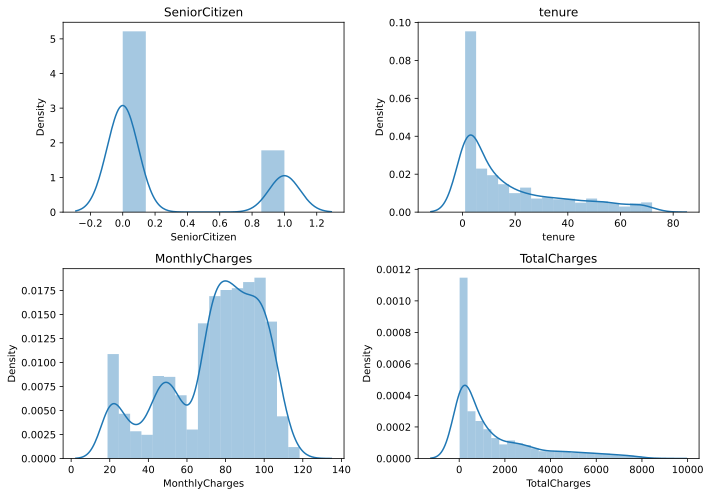

In [22]:
# Where the Churn == Yes
num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize = (10, 7))
nrows = 2
ncols = 2
iterator = 1
for i in num_cols:
    plt.subplot(nrows, ncols, iterator)
    sns.distplot(yes.loc[:, i])
    plt.title(i)
    iterator+=1
    
plt.tight_layout()
    
plt.show()

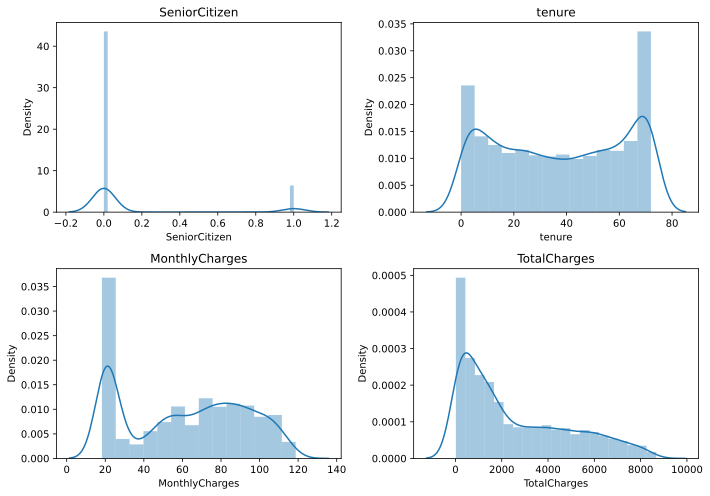

In [23]:
# Where the Churn == Yes

plt.figure(figsize = (10, 7))
nrows = 2
ncols = 2
iterator = 1
for i in num_cols:
    plt.subplot(nrows, ncols, iterator)
    sns.distplot(no.loc[:, i])
    plt.title(i)
    iterator+=1
    
plt.tight_layout()
    
plt.show()

In [24]:
yes.select_dtypes(include = np.number).describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,1869.000000,1869.000000,1869.000000,1869.000000
mean,0.254682,17.979133,74.441332,1531.796094
std,0.435799,19.531123,24.666053,1890.822994
min,0.000000,1.000000,18.850000,18.850000
25%,0.000000,2.000000,56.150000,134.500000
50%,0.000000,10.000000,79.650000,703.550000
75%,1.000000,29.000000,94.200000,2331.300000
max,1.000000,72.000000,118.350000,8684.800000


In [25]:
no.select_dtypes(include = np.number).describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5174.000000,5174.000000,5174.000000,5163.000000
mean,0.128721,37.569965,61.265124,2555.344141
std,0.334923,24.113777,31.092648,2329.456984
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,15.000000,25.100000,577.825000
50%,0.000000,38.000000,64.425000,1683.600000
75%,0.000000,61.000000,88.400000,4264.125000
max,1.000000,72.000000,118.750000,8672.450000


In [26]:
# Statistical Test for Numerical Columns - T Test

for i in num_cols:
    churn_yes = custData.loc[custData.Churn=="Yes", i]
    churn_no = custData.loc[custData.Churn=="No", i]
    teststats, pvalue = stats.ttest_ind(churn_yes, churn_no)
    if pvalue<0.05:
        print(i, ":Pvalue", pvalue)

SeniorCitizen :Pvalue 3.8398600557847846e-37
tenure :Pvalue 7.99905796059022e-205
MonthlyCharges :Pvalue 2.7066456068884154e-60


* **Inference:**  ``SeniorCitizen``, ``Tenure`` and ``Monthly Charges`` are Statistically Significant Variables.

In [27]:
custData.isnull().sum()[custData.isnull().sum()!=0]

TotalCharges    11
dtype: int64

In [28]:
custData.loc[custData.tenure==0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No,...,No,No,No,No,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No,...,No,No,No,No,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No,...,No,No,No,No,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No,...,No,No,No,No,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No,...,No,No,No,No,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No,...,No,No,No,No,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [29]:
# Replacing the 0 tenure with 1

custData.loc[custData.tenure==0, "tenure"]=1

In [30]:
# Lets Print the Index of the Rows where the Total Charges is Missing

custData.loc[custData.TotalCharges.isnull()].index

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

In [31]:
# Lets Create a DataFrame used for Dealing with Missing Values.

without_miss = custData.dropna()

In [32]:
# Lets Build a Linear Regression Model that will be used to Deal with the Missing values in TotalCharges Var.

from statsmodels.formula.api import ols

model = ols("TotalCharges~MonthlyCharges+tenure", data = without_miss).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TotalCharges   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 2.997e+04
Date:                Sat, 23 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:45:53   Log-Likelihood:                -56382.
No. Observations:                7032   AIC:                         1.128e+05
Df Residuals:                    7029   BIC:                         1.128e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2162.4319     21.990    -98.337      0.000   -2205.539   -2119.325
MonthlyCharges    35.8789      0.300    119.415      0.000      35.290      36.468
tenure            65.4141      0.368    177.622      0.000      64.692      66.136
==============================================================================
Omnibus:                       48.866   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.125
Skew:                           0.106   Prob(JB):                     3.19e-09
Kurtosis:                       2.702   Cond. No.                         198.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Lets Fill the Missing Value for the Whole Set of Rows where the Total Charges is Missing...

for i in custData.loc[custData.TotalCharges.isnull()].index:
    custData.loc[i, "TotalCharges"] = np.abs(model.params[0]+\
    model.params[1]*custData.loc[i, "MonthlyCharges"] + model.params[2]*custData.loc[i, "tenure"])

In [34]:
# lets recheck if there are any missing values...

custData.loc[custData.TotalCharges.isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


#### Feature Engineering

In [35]:
# Creating a New Feature Called Consolidated Charges & Other Charges

custData["ConsolidatedCharges"] = custData["tenure"]*custData["MonthlyCharges"]

custData["OtherCharges"] = np.abs(custData["ConsolidatedCharges"] - custData["TotalCharges"])

<Axes: xlabel='Churn', ylabel='OtherCharges'>

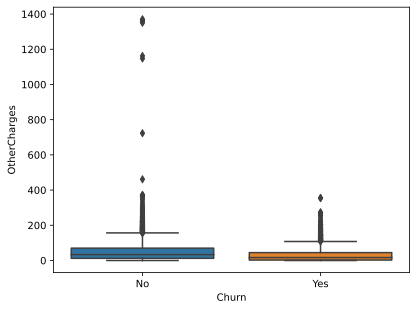

In [36]:
sns.boxplot(x = "Churn", y = "OtherCharges", data = custData)

In [37]:
yes_chgs = custData.loc[custData.Churn=="Yes", "OtherCharges"]
no_chgs = custData.loc[custData.Churn=="No", "OtherCharges"]

stats.ttest_ind(yes_chgs, no_chgs)

Ttest_indResult(statistic=-10.519931126010484, pvalue=1.083695769549733e-25)

Result: The ``OtherCharges`` Variable is Statistically Significant.

In [38]:
yes_chgs = custData.loc[custData.Churn=="Yes", "TotalCharges"]
no_chgs = custData.loc[custData.Churn=="No", "TotalCharges"]

stats.ttest_ind(yes_chgs, no_chgs)

Ttest_indResult(statistic=-17.01912270820074, pvalue=1.0983351237994025e-63)

Result: Now We see that ``TotalCharges`` is also a Significant Variable

**Lets Create a New DataFrame called 'Final' with Significant Features only**

In [39]:
final = custData.loc[:, signi_feats+["tenure", "MonthlyCharges", 
                       "ConsolidatedCharges", "TotalCharges", "OtherCharges"]]

In [40]:
final.head()

,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,ConsolidatedCharges,TotalCharges,OtherCharges
0,Yes,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,1,29.85,29.85,29.85,0.00
1,No,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,34,56.95,1936.30,1889.50,46.80
2,No,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,2,53.85,107.70,108.15,0.45
3,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,45,42.30,1903.50,1840.75,62.75
4,No,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,2,70.70,141.40,151.65,10.25


In [41]:
final.columns

Index(['Partner', 'Dependents', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn', 'tenure', 'MonthlyCharges',
       'ConsolidatedCharges', 'TotalCharges', 'OtherCharges'],
      dtype='object')

In [42]:
cols = ['Partner', 'Dependents', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 
       'PaperlessBilling', 'Churn']

dict_coded={"Yes":1, "No":0}

for i in cols:
    final[i] = [1 if value == 'Yes' else 0 for value in final[i]]
    final[i] = final[i].astype(float)

In [43]:
# Lets Check how to Encode the PaymentMethod

final.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [44]:
dict_pay = {'Electronic check':4, 'Mailed check':3, 'Bank transfer (automatic)':2,'Credit card (automatic)':1}

final["PaymentMethod"] = final["PaymentMethod"].map(dict_pay)

In [45]:
# Lets Check how to Encode the Contract

final.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [46]:
# Encoding Contract
dict_pay = {'Month-to-month':3, 'Two year':2, 'One year':1}

final["Contract"] = final["Contract"].map(dict_pay)

In [47]:
# Lets Check how to Encode the Internet Service

final["InternetService"].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [48]:
# Encoding InternetService

dict_pay = {'Fiber optic':3, 'DSL':2, 'No':1}

final["InternetService"] = final["InternetService"].map(dict_pay)

In [49]:
final.tail(20)

,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,ConsolidatedCharges,TotalCharges,OtherCharges
7023,1.0,0.0,1.0,3,0.0,1.0,1.0,0.0,1.0,1.0,3,1.0,4,0.0,63,103.50,6520.50,6479.40,41.10
7024,1.0,0.0,1.0,3,1.0,0.0,1.0,0.0,0.0,0.0,3,1.0,1,0.0,44,84.80,3731.20,3626.35,104.85
7025,0.0,0.0,1.0,3,0.0,0.0,1.0,1.0,0.0,1.0,3,1.0,2,0.0,18,95.05,1710.90,1679.40,31.50
7026,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,3,1.0,2,1.0,9,44.20,397.80,403.35,5.55
7027,0.0,0.0,0.0,2,0.0,1.0,0.0,1.0,1.0,1.0,3,0.0,3,0.0,13,73.35,953.55,931.55,22.00
7028,1.0,0.0,0.0,2,0.0,1.0,0.0,1.0,1.0,0.0,2,0.0,2,0.0,68,64.10,4358.80,4326.25,32.55
7029,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,1.0,1.0,3,1.0,4,0.0,6,44.40,266.40,263.05,3.35
7030,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,3,1.0,3,0.0,2,20.05,40.10,39.25,0.85
7031,1.0,0.0,1.0,2,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,1,0.0,55,60.00,3300.00,3316.10,16.10
7032,0.0,0.0,1.0,3,0.0,0.0,0.0,0.0,0.0,0.0,3,1.0,4,1.0,1,75.75,75.75,75.75,0.00


In [50]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Partner              7043 non-null   float64
 1   Dependents           7043 non-null   float64
 2   MultipleLines        7043 non-null   float64
 3   InternetService      7043 non-null   int64  
 4   OnlineSecurity       7043 non-null   float64
 5   OnlineBackup         7043 non-null   float64
 6   DeviceProtection     7043 non-null   float64
 7   TechSupport          7043 non-null   float64
 8   StreamingTV          7043 non-null   float64
 9   StreamingMovies      7043 non-null   float64
 10  Contract             7043 non-null   int64  
 11  PaperlessBilling     7043 non-null   float64
 12  PaymentMethod        7043 non-null   int64  
 13  Churn                7043 non-null   float64
 14  tenure               7043 non-null   int64  
 15  MonthlyCharges       7043 non-null   f

In [51]:
final.Churn.value_counts(normalize = False)

0.0    5174
1.0    1869
Name: Churn, dtype: int64

### Model Building
#### 4. Build a neural-network model using PyTorch (or other library of your choice) to predict customer churn.

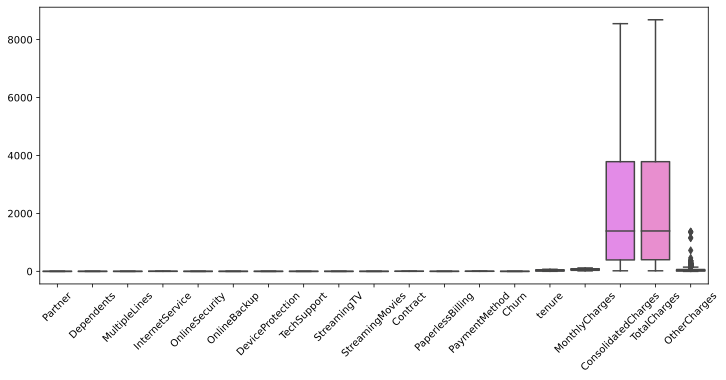

In [52]:
fig, ax = plt.subplots(1,figsize=(12,5))
ax = sns.boxplot(data=final)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [53]:
cols2zscore = final.keys()
cols2zscore = cols2zscore.drop('Churn')
final[cols2zscore] = final[cols2zscore].apply(stats.zscore)

final.describe()

,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,ConsolidatedCharges,TotalCharges,OtherCharges
count,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7043.000000,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03
mean,7.162933e-17,1.069396e-16,-1.281257e-16,-5.145205e-17,-2.534770e-17,5.561361e-17,3.379694e-17,8.222240e-17,-3.278807e-18,3.934569e-17,-1.891620e-16,-5.952296e-17,1.916841e-17,0.265370,8.070910e-17,-6.406285e-17,-7.389927e-17,-1.079484e-16,-3.581466e-17
std,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,0.441561,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-9.666223e-01,-6.540119e-01,-8.541762e-01,-1.570214e+00,-6.339330e-01,-7.255627e-01,-7.239675e-01,-6.394386e-01,-7.901317e-01,-7.960701e-01,-1.672366e+00,-1.205113e+00,-1.466165e+00,0.000000,-1.277614e+00,-1.545860e+00,-9.983845e-01,-9.985394e-01,-7.408619e-01
25%,-9.666223e-01,-6.540119e-01,-8.541762e-01,-2.862227e-01,-6.339330e-01,-7.255627e-01,-7.239675e-01,-6.394386e-01,-7.901317e-01,-7.960701e-01,-4.253069e-01,-1.205113e+00,-5.957106e-01,0.000000,-9.518238e-01,-9.725399e-01,-8.326970e-01,-8.296667e-01,-5.897262e-01
50%,-9.666223e-01,-6.540119e-01,-8.541762e-01,-2.862227e-01,-6.339330e-01,-7.255627e-01,-7.239675e-01,-6.394386e-01,-7.901317e-01,-7.960701e-01,8.217524e-01,8.297975e-01,2.747437e-01,0.000000,-1.373493e-01,1.857327e-01,-3.912759e-01,-3.913086e-01,-2.818572e-01
75%,1.034530e+00,1.529024e+00,1.170719e+00,9.977688e-01,1.577454e+00,1.378241e+00,1.381277e+00,1.563872e+00,1.265612e+00,1.256171e+00,8.217524e-01,8.297975e-01,1.145198e+00,1.000000,9.214675e-01,8.338335e-01,6.652467e-01,6.644984e-01,2.811034e-01
max,1.034530e+00,1.529024e+00,1.170719e+00,9.977688e-01,1.577454e+00,1.378241e+00,1.381277e+00,1.563872e+00,1.265612e+00,1.256171e+00,8.217524e-01,8.297975e-01,1.145198e+00,1.000000,1.613771e+00,1.794352e+00,2.768974e+00,2.826474e+00,2.117786e+01


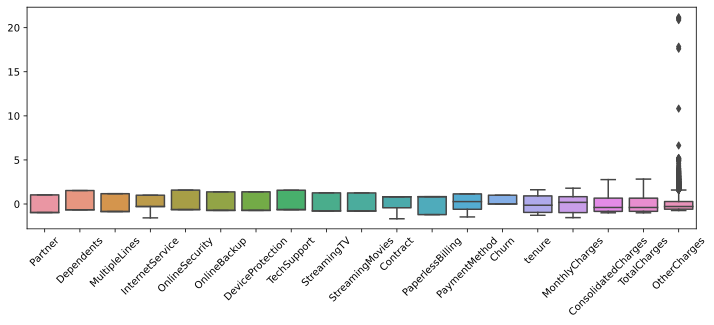

In [54]:
fig, ax = plt.subplots(1,figsize=(12,4))
ax = sns.boxplot(data=final)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [55]:
# remove the rows with outlier data
final = final[final['OtherCharges']<5]

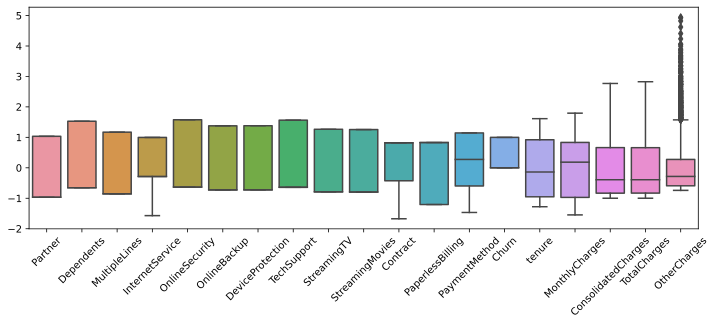

In [56]:
fig, ax = plt.subplots(1,figsize=(12,4))
ax = sns.boxplot(data=final)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [57]:
dataT = torch.tensor( final[cols2zscore].values).float()
labels = torch.tensor(final['Churn'].values ).float()

print(dataT.shape)
print(labels.shape)

labels = labels[:,None]
print(labels.shape)

torch.Size([7029, 18])
torch.Size([7029])
torch.Size([7029, 1])


#### 5. Split the data set in train (80%) and test (20%) sets. Train the model using the training set.

In [473]:
# Import necessary libraries for SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def custData():
    
    # NEW: put all outputs into a dictionary
    output = {}
    output['data'] = torch.tensor( final[cols2zscore].values).float()
    output['labels'] = torch.tensor(final['Churn'].values ).float()
    
    # use scikitlearn to split the data
    Xtrain,Xtest,ytrain,ytest = train_test_split(output['data'], output['labels'],train_size=0.8, random_state=36)
    
    # Assuming trainData and trainLabels are defined variables
    print("Variable 'trainData' is of type:", type(Xtrain))
    print("Variable 'trainLabels' is of type:", type(ytrain))
    
    # Convert train PyTorch tensors to NumPy arrays
    Xtrain_np = Xtrain.numpy()
    ytrain_np = ytrain.numpy()
    # Count the occurrences of 1.0 and 0.0
    count_ones = np.count_nonzero(ytrain_np == 1.0)
    count_zeros = np.count_nonzero(ytrain_np == 0.0)
    print(f"Number of 1.0's in train: {count_ones}")
    print(f"Number of 0.0's in train: {count_zeros}")
    
    
    # Convert test PyTorch tensors to NumPy arrays
    Xtest_np = Xtest.numpy()
    ytest_np = ytest.numpy()
    # Count the occurrences of 1.0 and 0.0
    count_tones = np.count_nonzero(ytest_np == 1.0)
    count_tzeros = np.count_nonzero(ytest_np == 0.0)
    print(f"Number of 1.0's in test: {count_tones}")
    print(f"Number of 0.0's in test: {count_tzeros}")

    # Apply SMOTE to the training data
    smote = SMOTE(sampling_strategy='auto', random_state=36)
    trainDResampled, trainLResampled = smote.fit_resample(Xtrain_np, ytrain_np)
    testDResampled, testLResampled = smote.fit_resample(Xtest_np, ytest_np)
    
    # Count the occurrences of 1.0 and 0.0
    count_RSones = np.count_nonzero(trainLResampled == 1.0)
    count_RSzeros = np.count_nonzero(trainLResampled == 0.0)

    print(f"Number of 1.0's for train after resampling: {count_RSones}")
    print(f"Number of 0.0's for train after resampling: {count_RSzeros}")
    
   
    # Convert the resampled data back to PyTorch tensors
    trainDResampled = torch.from_numpy(trainDResampled).float()
    trainLResampled = torch.from_numpy(trainLResampled).long()
      
    # then convert them into PyTorch Datasets (note: already converted to tensors)
    XtrainDataset = TensorDataset(trainDResampled, trainLResampled)
    XtestDataset = TensorDataset(Xtest, ytest)
    
    # finally, translate into dataloader objects
    batchsize = 32
    output['trainLoader'] = DataLoader(XtrainDataset, batch_size = batchsize, shuffle=True,drop_last = True)
    output['testLoader']  = DataLoader(XtestDataset, batch_size=XtestDataset.tensors[0].shape[0])
    
    return output

In [474]:
testingdF = custData()

Variable 'trainData' is of type: <class 'torch.Tensor'>
Variable 'trainLabels' is of type: <class 'torch.Tensor'>
Number of 1.0's in train: 1511
Number of 0.0's in train: 4112
Number of 1.0's in test: 358
Number of 0.0's in test: 1048
Number of 1.0's for train after resampling: 4112
Number of 0.0's for train after resampling: 4112


In [475]:
def createChurnPredNet(nUnits,nLayers):
    
    class ANNcustData(nn.Module):
        def __init__(self,nUnits,nLayers):
            super().__init__()
            
            ## crete dictonary to store the layers
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers

            ## input layer
            self.layers['input'] = nn.Linear(18,nUnits)
            
            ## hidden layers
            for i in range(1, nLayers):
                self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
                self.layers[f'bnorm{i}']  = nn.BatchNorm1d(nUnits)
                
            ## output layers
            self.layers['output'] = nn.Linear(nUnits,1,dtype = torch.float)


        # forward pass
        def forward(self,x):

            # input layer without Batch Norm
            x = self.layers['input'](x)

            # hidden layer
            for i in range(1,self.nLayers):
                x = F.relu((self.layers[f'hidden{i}'](self.layers[f'bnorm{i}'](x))))
                
            # return output layer
            x = torch.sigmoid(self.layers['output'](x))

            return x
        
    # create the model instance
    net = ANNcustData(nUnits,nLayers)
        
    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
    #return net, lossfun
    return net, optimizer

In [476]:
# test the model with fake input
nUnitsPerLayer = 19
nLayers = 4

net,opt = createChurnPredNet(nUnitsPerLayer,nLayers)
print(net)

# input is ten samples
input = torch.rand(18,18)
net(input)

ANNcustData(
  (layers): ModuleDict(
    (input): Linear(in_features=18, out_features=19, bias=True)
    (hidden1): Linear(in_features=19, out_features=19, bias=True)
    (bnorm1): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden2): Linear(in_features=19, out_features=19, bias=True)
    (bnorm2): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden3): Linear(in_features=19, out_features=19, bias=True)
    (bnorm3): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (output): Linear(in_features=19, out_features=1, bias=True)
  )
)


tensor([[0.4663],
        [0.4772],
        [0.4781],
        [0.4861],
        [0.5061],
        [0.4662],
        [0.4728],
        [0.5058],
        [0.4876],
        [0.4869],
        [0.4541],
        [0.5120],
        [0.5026],
        [0.5440],
        [0.4863],
        [0.4882],
        [0.4696],
        [0.4720]], grad_fn=<SigmoidBackward0>)

In [477]:
# a function to count the number of units
def countUnits(model):
    totalUnits = 0
    for layer in model.modules():
        if isinstance(layer, torch.nn.modules.linear.Linear):
            totalUnits += layer.in_features
    return totalUnits


nNodesInModel = 300
layersRange   = [ 1,5,10,20 ]

# print out the model architectures
for lidx,layers in enumerate(layersRange):
    # create a model
    unitsperlayer = int(nNodesInModel//layersRange[lidx])
    net = createChurnPredNet(unitsperlayer,layers)[0]
    
    # count and print the results
    print(f'Units/layer: {unitsperlayer}, layers: {layers}, Total count: {countUnits(net)}')

Units/layer: 300, layers: 1, Total count: 318
Units/layer: 60, layers: 5, Total count: 318
Units/layer: 30, layers: 10, Total count: 318
Units/layer: 15, layers: 20, Total count: 318


In [484]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# train the model
# global parameter
numepochs = 10

def lossfun(yHat, y):
    y = y.float()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(yHat, y)
    
    return loss

def trainTheModel(nUnits,nLayers):
    
    # create a new model
    net, optimizer = createChurnPredNet(nUnits, nLayers)
        
    #initial losses
    losses      = torch.zeros(numepochs)
    trainAcc    = []
    testAcc     = []
    precision   = []
    recall      = []
    f1          = []
    
    # loop over epocs
    for epochi in range(numepochs):
        
        net.train()
        batchAcc = []
        batchLoss = []
        
        for X,y in train_data:
            
            yHat = net(X)
            
            y = y.view(-1, 1)
            
            loss = lossfun(yHat,y)
            
            #backdrop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # loss from this batch
            batchLoss.append(loss.sum().item())
            
            # compute accuracy
            matches = (yHat > 0.5).long() == y
            matchesNumeric = matches.float()
            accuracypct = 100*torch.mean(matchesNumeric)
            batchAcc.append( accuracypct )
            
        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        
        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)
        
        # test accuracy
        net.eval()
        y_true_test = []
        y_pred_test = []
        for X, y in test_data:
            with torch.no_grad():
                yHat = net(X)
            y_true_test.extend(y.cpu().numpy())
            y_pred_test.extend(torch.argmax(yHat, axis=1).cpu().numpy() )
            #y_pred_test_float = [float(value) for value in y_pred_test]
            y_true_testI = [int(value) for value in y_true_test]
            y_pred_testI = [int(value) for value in y_pred_test]
        # compare the following really long line of code to the training accuracy lines
        # calculate metrics for the test set
        testAccuracy  = accuracy_score(y_true_test, y_pred_test)
        
        
        testPrecision = precision_score(y_true_testI, y_pred_testI, average='binary')
        testRecall    = recall_score(y_true_testI, y_pred_testI, average='binary')
        testf1Score   = f1_score(y_true_testI, y_pred_testI, average='binary')
        
        # print test accurarcy, precision, recall and f1 score
        print(f'For Epoc: {epochi}, Test Accuracy: {testAccuracy}, Precision: {testPrecision:.3f}, Recall Score: {testRecall:.3f}, & f1 Score: {testf1Score:.3f}')
        
        testAcc.append(100 * testAccuracy)
        precision.append(testPrecision)
        recall.append(testRecall)
        f1.append(testf1Score)
        
    return trainAcc, testAcc, losses, precision, recall, f1, net

In [488]:
# before the experiment, configure and confirm the metaparameters

# specify the parameters for the model
nNodesInModel = 50
layersRange   = [ 1,5,10 ]
nDatapoints   = np.arange(10,50,5)

# create a legend for later plotting
legend = []

# print out the model architectures
for lidx,layers in enumerate(layersRange):
    # create a model
    unitsperlayer = int(nNodesInModel/layersRange[lidx])
    net = createChurnPredNet(unitsperlayer,layers)[0]
    
    # count its parameters
    nparams = np.sum([ p.numel() for p in net.parameters() if p.requires_grad ])
    
    legend.append( '%s layers, %s units, %s params' %(layers,unitsperlayer,nparams) )
    print('This model will have %s layers, each with %s units, totalling %s parameters' %(layers,unitsperlayer,nparams))

This model will have 1 layers, each with 50 units, totalling 1001 parameters
This model will have 5 layers, each with 10 units, totalling 721 parameters
This model will have 10 layers, each with 5 units, totalling 461 parameters


In [489]:
# initialize results matrix
results = np.zeros((len(nDatapoints),len(layersRange),5))

for didx,pnts in enumerate(nDatapoints):
    
    # create data (note: same data for each layer manipulation!)
    theData    = custData()
    train_data = theData['trainLoader']
    test_data  = theData['testLoader']
    
    # now loop over layers
    for lidx,layers in enumerate(layersRange):
        
        unitsperlayer = int(nNodesInModel/layersRange[lidx])
        print(f"Iteration {didx}-{lidx}:")
        trainAcc, testAcc, losses, precision, recall, f1, net = trainTheModel(unitsperlayer, layers)
        # Print metrics for each iteration, average of last 5 accuracies and losses
        # Store metrics in the results matrix
        results[didx, lidx, 0] = np.mean(testAcc[-5:])
        results[didx, lidx, 1] = torch.mean(losses[-5:]).item()
        results[didx, lidx, 2] = np.mean(precision[-5:])  # Store precision
        results[didx, lidx, 3] = np.mean(recall[-5:])     # Store recall
        results[didx, lidx, 4] = np.mean(f1[-5:])         # Store F1 score

Variable 'trainData' is of type: <class 'torch.Tensor'>
Variable 'trainLabels' is of type: <class 'torch.Tensor'>
Number of 1.0's in train: 1511
Number of 0.0's in train: 4112
Number of 1.0's in test: 358
Number of 0.0's in test: 1048
Number of 1.0's for train after resampling: 4112
Number of 0.0's for train after resampling: 4112
Iteration 0-0:
For Epoc: 0, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 1, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 2, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 3, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 4, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 5, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 6, Test Accu

For Epoc: 8, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 9, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
Iteration 2-1:
For Epoc: 0, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 1, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 2, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 3, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 4, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 5, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 6, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 7, Test Accuracy: 0.7453769559

For Epoc: 9, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
Iteration 4-2:
For Epoc: 0, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 1, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 2, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 3, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 4, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 5, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 6, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 7, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 8, Test Accuracy: 0.7453769559

Number of 1.0's for train after resampling: 4112
Number of 0.0's for train after resampling: 4112
Iteration 7-0:
For Epoc: 0, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 1, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 2, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 3, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 4, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 5, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 6, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 7, Test Accuracy: 0.7453769559032717, Precision: 0.000, Recall Score: 0.000, & f1 Score: 0.000
For Epoc: 8, Test Accuracy: 0.7453769559032717,

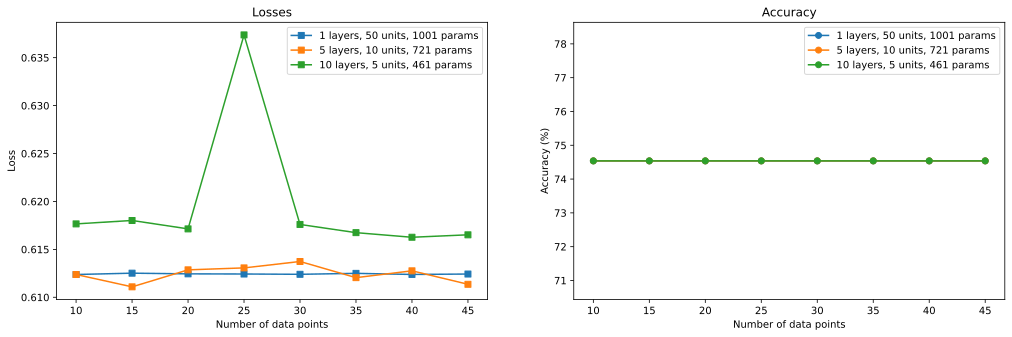

In [490]:
# show the results!

fig,ax = plt.subplots(1,2,figsize=(17,5))
ax[0].plot(nDatapoints,results[:,:,1],'s-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Number of data points')
ax[0].legend(legend)
ax[0].set_title('Losses')

ax[1].plot(nDatapoints,results[:,:,0],'o-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Number of data points')
ax[1].set_title('Accuracy')
ax[1].legend(legend)
plt.show()

In [491]:
print('Results DF:\n',results)

Results DF:
 [[[74.53769559  0.61237776  0.          0.          0.        ]
  [74.53769559  0.61237806  0.          0.          0.        ]
  [74.53769559  0.61765909  0.          0.          0.        ]]

 [[74.53769559  0.61251688  0.          0.          0.        ]
  [74.53769559  0.61109048  0.          0.          0.        ]
  [74.53769559  0.61801541  0.          0.          0.        ]]

 [[74.53769559  0.61244589  0.          0.          0.        ]
  [74.53769559  0.61286354  0.          0.          0.        ]
  [74.53769559  0.61713892  0.          0.          0.        ]]

 [[74.53769559  0.61243021  0.          0.          0.        ]
  [74.53769559  0.61306745  0.          0.          0.        ]
  [74.53769559  0.63737404  0.          0.          0.        ]]

 [[74.53769559  0.61239904  0.          0.          0.        ]
  [74.53769559  0.61373544  0.          0.          0.        ]
  [74.53769559  0.61759901  0.          0.          0.        ]]

 [[74.53769559  0